Fast Exact Retrieval for Nearest-neighbor Search

In [6]:
!pip install sortedcontainers matplotlib numpy
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import random
import sys
# from sortedcontainers import SortedDict


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
## Create red black tree datastructure

class VectorNode:
    def __init__(self, vector):
        self.vector = vector
        self.left = None
        self.right = None
        self.parent = None
        self.isRed = True
        self.depth = 0

class VectorTree:
    def __init__(self):
        self.root = VectorNode(None)
        self.root.isRed = False
        self.max_depth = 0

    def insert(self, vector):
        if self.root is None:
            self.root = VectorNode(vector)
            self.root.isRed = False
        else:
            node = self._insert(vector, self.root)
            # self._fix_tree(node)

    def _insert(self, vector, node):
        if node.left is None:
            node.left = VectorNode(vector)
            node.left.parent = node
            node.left.isRed = True
            node.left.depth = node.depth + 1
            self.max_depth = max(node.left.depth, self.max_depth)
            return node.left
        elif node.right is None:
            node.right = VectorNode(vector)
            node.right.parent = node
            node.right.isRed = True
            node.right.depth = node.depth + 1
            self.max_depth = max(node.right.depth, self.max_depth)
            return node.right
        elif self.compare(vector, node.left.vector, node.right.vector)[0] < 0:
            return self._insert(vector, node.left)
        else:
            return self._insert(vector, node.right)

    def retrieve_nearest(self, query):
        """
        Retrieve the nearest (by cosine similarity) neighbor to the given vector.
        """
        # distances = SortedDict()
        # mip is maximum inner product
        mip, mip_vector = sys.float_info.max, None
        curr = None
        queue = [self.root] # queue of VectorNodes to visit
        num_visited = 0

        while queue:
            curr = queue.pop(0)
            num_visited += 1
            if curr is not self.root:
                mip, mip_vector = self.closest(mip, mip_vector, curr.vector, query)
            if curr.left and curr.right:
                lr_dot, can_prune = self.compare(query, curr.left.vector, curr.right.vector)
                if lr_dot <= 0:
                    queue.append(curr.left)
                    if not can_prune: 
                        queue.append(curr.right)
                else:
                    queue.append(curr.right)
                    if not can_prune: 
                        queue.append(curr.left)
            else:
                if curr.left:
                    queue.append(curr.left)
                elif curr.right:
                    queue.append(curr.right)

        return mip_vector, num_visited
    
    def closest(self, min_dist, nn_vector, vector, query):
        vq_dist = self.euclidean_distance(vector, query)
        if vq_dist < min_dist:
            return vq_dist, vector
        return min_dist, nn_vector
    
    def cosine_similarity(self, v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

    def euclidean_distance(self, v1, v2):
        return np.linalg.norm(v1 - v2)
        
    def compare(self, query, v1, v2):
        """
            if v1 is closer to query than v2, compare() < 0
        """
        v1v2_dist = self.euclidean_distance(v1, v2) ** 2
        proportion_v2_euc = np.dot(v1-v2, query-v2) / v1v2_dist
        proportion_v1_euc = np.dot(v2-v1, query-v1) / v1v2_dist
        # q_v1_dot = self.cosine_similarity(query, v1)
        # q_v2_dot = self.cosine_similarity(query, v2)
        # proportion_v1_ip = q_v1_dot / (q_v1_dot + q_v2_dot) # proportion of inner product that v1 contributes
        # can_prune = proportion_v2_euc < 0.25 or proportion_v2_euc > 0.75 # whether the sub-tree rooted at v1 or v2 can be pruned
        can_prune = True
        # print("'closeness' of query to v2 vector:", proportion_v2_euc)
        return 0.5 - proportion_v2_euc, can_prune
    


100%|█████████████████████████████| 10000000/10000000 [41:06<00:00, 4054.67it/s]


Retrieval times: [0.00018388199806213378, 0.00023108220100402833, 0.00026600265502929685, 0.00029741501808166506, 0.00033739185333251954, 0.00036160778999328613]
Proportion of vectors traversed: [0.0014942, 0.0001876, 4.2380000000000004e-05, 2.2744e-05, 4.9848e-06, 2.6521e-06]
Recall rate: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Max tree depths: [21, 27, 31, 34, 38, 41]


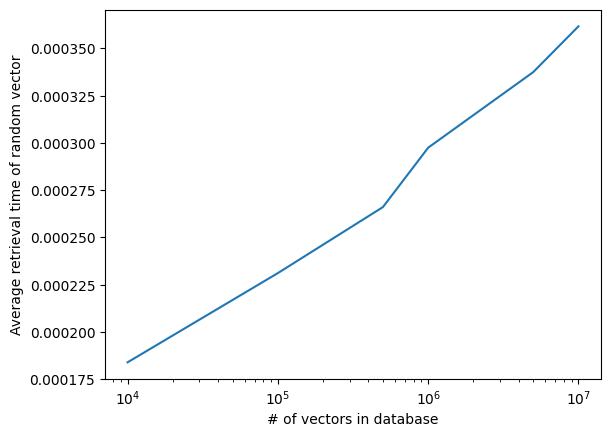

In [8]:
## test
import numpy as np

# create a list of num_vectors
num_vectors = [1, 10, 50, 100, 500, 1000]
num_vectors = [10_000*e for e in num_vectors]

dim = 128

# create an empty list to store retrieval times for each trial
retrieval_times = []
# avg. proportion of graph traversed per num_vectors item
proportion_traversed = []

# avg. recall per num_vectors item
recalls = []
# max tree depth per tree
max_tree_depths = []

# for each num_vector
for num_vector in num_vectors:
    # create a VectorTree object
    tree = VectorTree()
    vector_db = [] # list of all vectors

    # insert num_vector random vectors
    for i in tqdm(range(num_vector)):
        vector = np.random.rand(dim)
        vector /= np.linalg.norm(vector)
        # vector = np.random.randint(2, size=dim)
        tree.insert(vector)
        vector_db.append(vector)
    
    # create an empty list to store retrieval times for this num_vector configuration
    retrieval_times_for_selected_vector = []
    num_visited_for_selected_vector = []
    recall_for_selected_vector = []
    # for each retrieval
    for query in random.sample(vector_db, 1000):
        # query = np.random.rand(dim)
        # query /= np.linalg.norm(query)
        # query = np.random.randint(2, size=dim)
        start_time = time.time()
        vector, num_visited = tree.retrieve_nearest(query)
        end_time = time.time()
        # if not np.array_equal(np.array(vector), np.array(selected_vector)):
        #     print("Error")
        retrieval_time = end_time - start_time
        retrieval_times_for_selected_vector.append(retrieval_time)
        num_visited_for_selected_vector.append(num_visited)
        recall_for_selected_vector.append(np.array_equal(np.array(vector), np.array(query)))
        
        
    retrieval_times.append(sum(retrieval_times_for_selected_vector) / len(retrieval_times_for_selected_vector))
    proportion_traversed.append(sum(num_visited_for_selected_vector) / len(num_visited_for_selected_vector) / num_vector)
    recalls.append(sum(recall_for_selected_vector) / len(recall_for_selected_vector))
    max_tree_depths.append(tree.max_depth)

print("Retrieval times:", retrieval_times)
print("Proportion of vectors traversed:", proportion_traversed)
print("Recall rate:", recalls)
print("Max tree depths:", max_tree_depths)
# plot the average retrieval times for this num_vector
plt.plot(num_vectors, retrieval_times, label=str(num_vector))
    
# set the x-axis label and legend
plt.xlabel('# of vectors in database')
plt.ylabel('Average retrieval time of random vector')
# plt.legend(title='Number of vectors')
plt.xscale('log')
plt.show()


In [9]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              80
On-line CPU(s) list: 0-79
Thread(s) per core:  1
Core(s) per socket:  40
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               106
Model name:          Intel(R) Xeon(R) Platinum 8380 CPU @ 2.30GHz
Stepping:            6
CPU MHz:             3400.000
CPU max MHz:         3400.0000
CPU min MHz:         800.0000
BogoMIPS:            4600.00
Virtualization:      VT-x
L1d cache:           48K
L1i cache:           32K
L2 cache:            1280K
L3 cache:            61440K
NUMA node0 CPU(s):   0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78
NUMA node1 CPU(s):   1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep